In [1]:
from datetime import date

import pandas as pd
import numpy as np
import geopandas as gpd

import xarray as xr
import datetime
import matplotlib.pyplot as plt

# Import the function to get connect to the db
from snowexsql.db import get_db
# Import for database tables
from snowexsql.data import LayerData, PointData, ImageData, SiteData
# Import the function to investigate a table
from snowexsql.db import get_table_attributes
# Import a useful function to format that data into a dataframe
from snowexsql.conversions import query_to_geopandas

Connect to SnowEx database

In [2]:
# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

Connect to LayerData table

In [3]:
# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(LayerData)

# Print out the results nicely
print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))

These are the available columns in the table:
 
* bottom_depth
* comments
* date
* date_accessed
* depth
* doi
* easting
* elevation
* flags
* geom
* instrument
* latitude
* longitude
* metadata
* northing
* observers
* pit_id
* registry
* sample_a
* sample_b
* sample_c
* site_id
* site_name
* time
* time_created
* time_updated
* type
* units
* utm_zone
* value



Make a query of temperature profiles

In [79]:
# Pick a dataset
dataset = 'temperature'
# Pick a date
#collection_date = date(2020, 2, 8)

# Make the query
qry = session.query(LayerData).filter(LayerData.type == 'temperature')#.filter(LayerData.date == collection_date)
# Limit it to a couple thousand 
qry = qry.limit(20000)

# Execute the query and convert to geopandas in one handy function
df = query_to_geopandas(qry, engine)

# how many did we retrieve?
print(f'{len(df.index)} records returned!')

6574 records returned!


close the db session

In [80]:
# Close the session to avoid hanging transactions
session.close()

---

Convert geodataframe into an xarray dataset

In [81]:
# Create a datetime column combining date and time
df['datetime'] = [datetime.datetime.combine(row.date, row.time) for _, row in df.iterrows()]

Save to csv

In [82]:
#df.to_csv('snowex2020_snowpit_temperatures.csv')

columns: `index, Location, Type, Easting, Northing, Surveyor, Time, Time Type, Air Temp, Ground, Notes,Wx,Hs,Temperature,Notes,geometry`

unpack the columns we want from the dataframe

In [83]:
# unpack values from dataframe that we want, make sure to set the datatypes we want
time = df.datetime.values
depth = df.depth.values.astype(np.float64)
northing = df.northing.values.astype(np.float64)
easting = df.easting.values.astype(np.float64)
longitude = df.longitude.values.astype(np.float64)
latitude = df.latitude.values.astype(np.float64)
temperature = df.value.values.astype(np.float64)
geometry = df.geom.values
site_id = df.site_id

Build a dataset from these columns

In [84]:
# build a dataset
ds = xr.Dataset(
    data_vars=dict(
        temperature=(["time"], temperature),
        geometry=(["geometry"], geometry)
    ),
    coords=dict(
        #lon=(["time"], longitude),
        #lat=(["time"], latitude),
        easting=(["time"], easting),
        northing=(["time"],northing),
        depth=(["time"], depth),
        time=(["time"], time),
        site_id=(["time"], site_id)
    ),
    attrs=dict(description="snow pit temperature dataset"),
)

Save as netcdf

In [85]:
#ds.to_netcdf('snowex2020_snowpit_temperatures.nc')

Try making some plots

In [86]:
# select only points on grand mesa
ds_gm = ds.where((ds.easting > 700000) & (ds.easting < 750000) & (ds.northing < 4350000), drop=True)

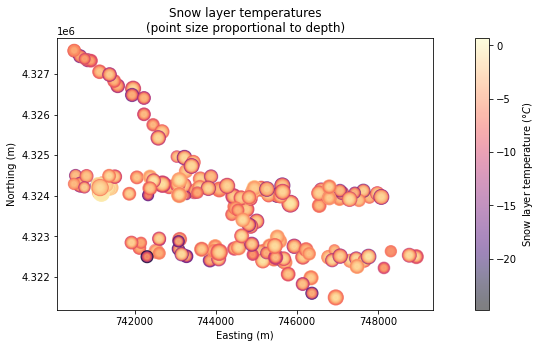

In [87]:
plt.figure(figsize=(15,5))



plt.scatter(x=ds_gm.easting,y=ds_gm.northing, c=ds_gm.temperature, s=ds_gm.depth*2, alpha=0.5, cmap='magma')

plt.colorbar(label='Snow layer temperature ($\degree C$)');


plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.title('Snow layer temperatures\n(point size proportional to depth)')

plt.gca().set_aspect('equal')

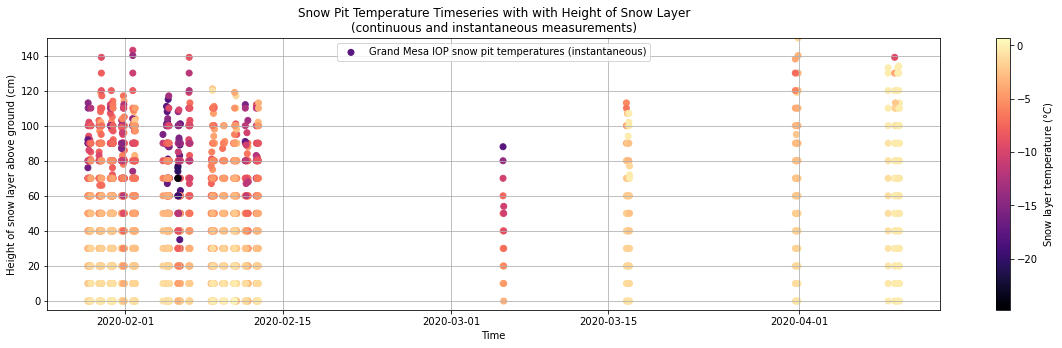

In [88]:
plt.figure(figsize=(20,5))


# Plot asll other snowpit temperatures over time
plt.scatter(x=ds_gm.time, y=ds_gm.depth, c=ds_gm.temperature, cmap='magma', marker='o', label='Grand Mesa IOP snow pit temperatures (instantaneous)')


plt.colorbar(label='Snow layer temperature ($\degree C$)')



# set axes limits
plt.ylim((-5,150))
#plt.xlim((pd.Timestamp(2020,2,5,11,0),pd.Timestamp(2020,2,12,16,0)))

# add a legend to the plot
plt.legend()

# set axes labels
plt.xlabel('Time')
plt.ylabel('Height of snow layer above ground (cm)')

# add grid lines to the plot
plt.grid('on')

# set the plot title
plt.title('Snow Pit Temperature Timeseries with with Height of Snow Layer\n(continuous and instantaneous measurements)');

# save figure
#plt.savefig('snow_pit_temp_timeseries_by_depth_all_data.jpg')

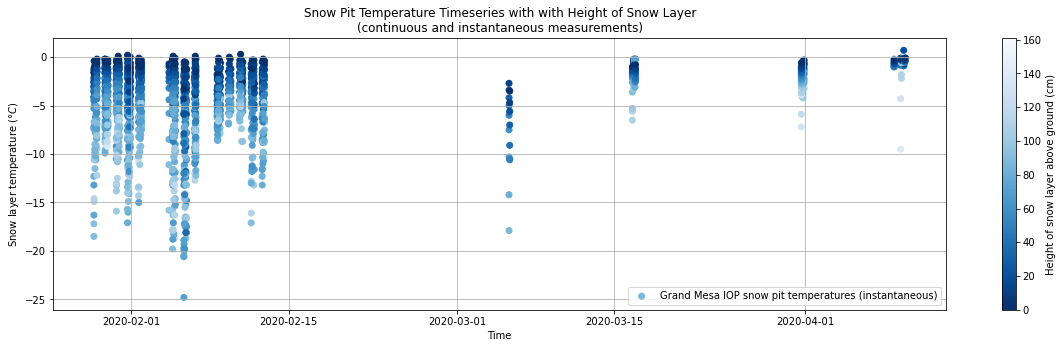

In [89]:
plt.figure(figsize=(20,5))


# Plot asll other snowpit temperatures over time
plt.scatter(x=ds_gm.time, y=ds_gm.temperature, c=ds_gm.depth, cmap='Blues_r', marker='o', label='Grand Mesa IOP snow pit temperatures (instantaneous)')


plt.colorbar(label='Height of snow layer above ground (cm)')



# set axes limits
#plt.ylim((-5,150))
#plt.xlim((pd.Timestamp(2020,2,5,11,0),pd.Timestamp(2020,2,12,16,0)))

# add a legend to the plot
plt.legend()

# set axes labels
plt.xlabel('Time')
plt.ylabel('Snow layer temperature ($\degree C$)')

# add grid lines to the plot
plt.grid('on')

# set the plot title
plt.title('Snow Pit Temperature Timeseries with with Height of Snow Layer\n(continuous and instantaneous measurements)');

# save figure
#plt.savefig('snow_pit_temp_timeseries_by_depth_all_data.jpg')

For each snow pit (each unique time stamp) get the snow temperature for the top-most snow layer, total snow depth, easting and northing coordinates.

In [90]:
times = []
snow_depths_max = []
surface_temperatures = []
eastings = []
northings = []
geometries = []
site_ids = []

done_sites = []
for i, this_site in enumerate(ds_gm.site_id.values):
    if this_site not in done_sites:
        done_sites.append(this_site)
        ds_this_site = ds_gm.where(ds_gm.site_id==this_site, drop=True)
        snow_depth_max = ds_this_site.depth.max()
        surface_temperature = ds_this_site.temperature[ds_this_site.depth == snow_depth_max]
        easting = ds_this_site.easting[ds_this_site.depth == snow_depth_max]
        northing = ds_this_site.northing[ds_this_site.depth == snow_depth_max]
        site_id = ds_this_site.site_id[ds_this_site.depth == snow_depth_max]
        times.append(ds_this_site.time.values[0])
        snow_depths_max.append(snow_depth_max.values.ravel()[0])
        surface_temperatures.append(surface_temperature.values[0])
        eastings.append(easting.values[0])
        northings.append(northing.values[0])
        site_ids.append(site_id.values[0])

In [91]:
d = {'time': times, 'site_id': site_ids, 'depth': snow_depths_max, 'easting': eastings, 'northing': northings, 'temperature': surface_temperatures}

df_tss = pd.DataFrame(data=d)

In [92]:
df_tss = df_tss.set_index('time').sort_index()

Create a geometry for each of the ground points in the snow pit surface temperature dataframe

In [93]:
df_tss['geometry'] = gpd.points_from_xy(df_tss.easting, df_tss.northing, crs='EPSG:26912').to_crs('EPSG:32613')
df_tss['easting'] =  [this_geom.x for this_geom in df_tss.geometry]
df_tss['northing'] =  [this_geom.y for this_geom in df_tss.geometry]

Export as csv

In [94]:
df_tss.to_csv('snowex2020_snowpit_surface_temperatures.csv')

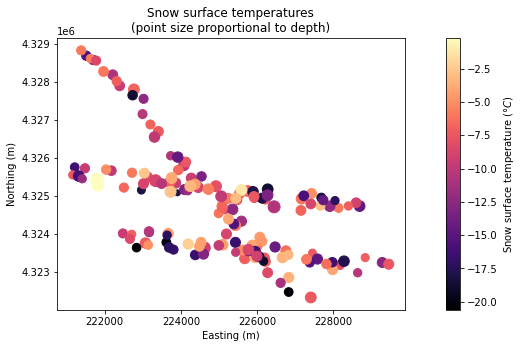

In [95]:
plt.figure(figsize=(15,5))

plt.scatter(x=df_tss.easting,y=df_tss.northing, c=df_tss.temperature, s=df_tss.depth, alpha=1, cmap='magma')

plt.colorbar(label='Snow surface temperature ($\degree C$)');


plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.title('Snow surface temperatures\n(point size proportional to depth)')

plt.gca().set_aspect('equal')

C:\Users\steve\AppData\Local\Temp\ipykernel_24348\3079563929.py:4: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  df_tss.resample('6H', loffset='3H').mean().temperature.plot(linestyle='none', marker='D', markersize=7, color='k', ax=ax, label='6-hour mean snow pit surface temperature')


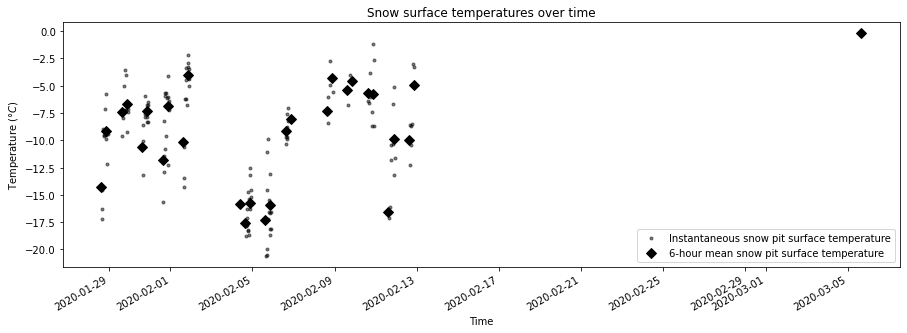

In [96]:
fig, ax = plt.subplots(figsize=(15,5))

df_tss.temperature.plot(linestyle='none',marker='.', color='k', alpha=0.5, ax=ax, label='Instantaneous snow pit surface temperature')
df_tss.resample('6H', loffset='3H').mean().temperature.plot(linestyle='none', marker='D', markersize=7, color='k', ax=ax, label='6-hour mean snow pit surface temperature')


ax.set_xlabel('Time')
ax.set_ylabel('Temperature ($\degree C$)')
ax.set_title('Snow surface temperatures over time')
plt.legend()

C:\Users\steve\AppData\Local\Temp\ipykernel_24348\3760113348.py:4: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  df_tss.resample('6H', loffset='3H').mean().temperature.plot(linestyle='none', marker='D', markersize=7, color='k', ax=ax, label='6-hour mean snow pit surface temperature')


(18293.0, 18305.0)

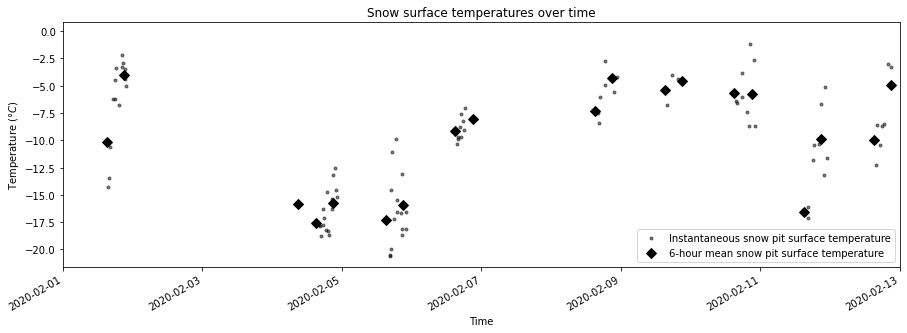

In [117]:
fig, ax = plt.subplots(figsize=(15,5))

df_tss.temperature.plot(linestyle='none',marker='.', color='k', alpha=0.5, ax=ax, label='Instantaneous snow pit surface temperature')
df_tss.resample('6H', loffset='3H').mean().temperature.plot(linestyle='none', marker='D', markersize=7, color='k', ax=ax, label='6-hour mean snow pit surface temperature')


ax.set_xlabel('Time')
ax.set_ylabel('Temperature ($\degree C$)')
ax.set_title('Snow surface temperatures over time')
plt.legend()

ax.set_xlim(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-02-13'))

Load in ground data from snow pit 2S10

In [97]:
df_merged = pd.read_csv(r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\Mountain GOES Paper\Paper 2 - satellite vs ground\GOES-16_ABI_data\merged_datasets.csv')
df_merged.set_index(pd.to_datetime(df_merged.datetime), inplace=True)
df_merged.head()

,datetime,pxA_t,pxA_x_2km,pxA_y_2km,pxA_x_1km_W,pxA_x_1km_E,pxA_y_1km_N,pxA_y_1km_S,pxA_b1_rad_1km_NW,pxA_b1_rad_1km_NE,...,pxE_b13_rad_2km,pxE_b13_tb_2km,pxE_b14_rad_2km,pxE_b14_tb_2km,pxE_b15_rad_2km,pxE_b15_tb_2km,pxE_b16_rad_2km,pxE_b16_tb_2km,rad_avg,AirTC_20ft_Avg
datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-07 00:01:00,2020-02-07 00:01:00,2020-02-07 00:01:00,-0.03136,0.08624,-0.071022,-0.070994,0.104762,0.104706,72.328224,88.570351,...,34.801651,242.573807,41.784950,241.685333,49.698959,240.644302,53.212227,237.141129,265.9963,265.477000
2020-02-07 00:06:00,2020-02-07 00:06:00,2020-02-07 00:06:00,-0.03136,0.08624,-0.071022,-0.070994,0.104762,0.104706,63.395058,74.764542,...,34.893108,242.684448,41.883934,241.792435,49.857281,240.800369,53.036167,236.971130,265.9010,265.504167
2020-02-07 00:11:00,2020-02-07 00:11:00,2020-02-07 00:11:00,-0.03136,0.08624,-0.071022,-0.070994,0.104762,0.104706,49.589249,55.273994,...,34.984566,242.794876,41.933426,241.845932,49.751732,240.696350,52.860111,236.800797,265.8292,265.531333
2020-02-07 00:16:00,2020-02-07 00:16:00,2020-02-07 00:16:00,-0.03136,0.08624,-0.071022,-0.070994,0.104762,0.104706,35.783440,43.904503,...,35.761955,243.725967,43.319206,243.327560,51.493279,242.395920,54.444637,238.322113,265.8386,265.558500
2020-02-07 00:21:00,2020-02-07 00:21:00,2020-02-07 00:21:00,-0.03136,0.08624,-0.071022,-0.070994,0.104762,0.104706,28.474478,27.662374,...,34.390087,242.073639,41.784950,241.685333,49.857281,240.800369,53.212227,237.141129,265.8273,265.585667


In [98]:
df_tss

,site_id,depth,easting,northing,temperature,geometry
time,,,,,,
2020-01-28 16:13:00,6N18,92.0,223785.163549,4.325401e+06,-17.2,POINT (223785.164 4325401.028)
2020-01-28 16:15:00,4N2,76.0,221206.832736,4.325763e+06,-16.3,POINT (221206.833 4325762.919)
2020-01-28 16:40:00,9N59,113.0,228702.033468,4.324738e+06,-14.6,POINT (228702.033 4324738.245)
2020-01-28 17:54:00,8N58,94.0,228608.773943,4.324829e+06,-9.0,POINT (228608.774 4324828.604)
2020-01-28 18:25:00,2N4,86.0,221475.517726,4.325733e+06,-9.6,POINT (221475.518 4325733.130)
...,...,...,...,...,...,...
2020-02-12 18:26:00,1C5,82.0,221771.070770,4.328566e+06,-8.5,POINT (221771.071 4328566.467)
2020-02-12 19:57:00,5N32,102.0,225445.937698,4.324943e+06,-3.0,POINT (225445.938 4324943.431)
2020-02-12 20:45:00,5N24,113.0,224244.185348,4.325263e+06,-3.3,POINT (224244.185 4325263.432)


(18300.0, 18305.0)

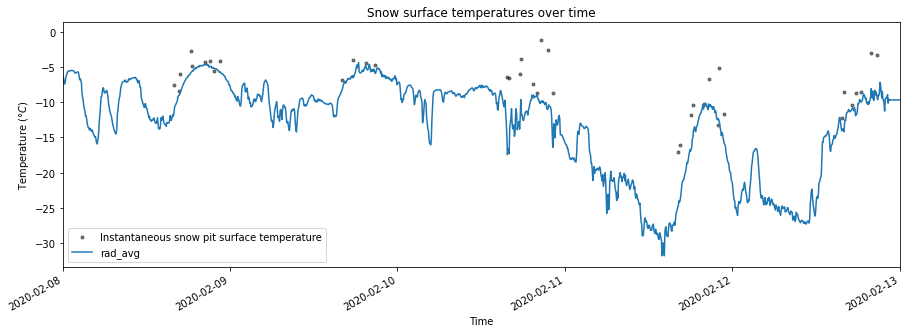

In [106]:
fig, ax = plt.subplots(figsize=(15,5))

df_tss.temperature.plot(linestyle='none',marker='.', color='k', alpha=0.5, ax=ax, label='Instantaneous snow pit surface temperature')
#df_tss.resample('6H', loffset='3H').mean().temperature.plot(linestyle='none', marker='D', markersize=7, color='k', ax=ax, label='6-hour mean snow pit surface temperature')
(df_merged.rad_avg-273.15).plot()

ax.set_xlabel('Time')
ax.set_ylabel('Temperature ($\degree C$)')
ax.set_title('Snow surface temperatures over time')
plt.legend()

ax.set_xlim(pd.Timestamp('2020-02-08'), pd.Timestamp('2020-02-13'))

---

Load airborne IR flights from Feb 8

In [121]:
import ir_utils

In [122]:
files = [r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb08_mosaicked.mat',
         r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_EO_PLANE_2020Feb08_mosaicked.mat',
         r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb11_mosaicked.mat',
         r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_EO_PLANE_2020Feb11_mosaicked.mat',
         # r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb12_mosaicked.mat'
        ]

In [123]:


ds_eo = ir_utils.eo_mat2dataset(files[1])
#ds_eo['SRGB'] = ds_eo.SRGB.transpose('time', 'y', 'x','band')

ds_ir = ir_utils.ir_mat2dataset(files[0])
#ds_ir['STCtemp'] = ds_ir.STCtemp.transpose('time', 'y', 'x').rio.reproject('EPSG:26912')

In [124]:
ds_ir

<xarray.Dataset>
Dimensions:      (x: 4171, y: 3581, time: 17)
Coordinates:
  * x            (x) int32 218150 218155 218160 218165 ... 238990 238995 239000
  * y            (y) int32 4314100 4314105 4314110 ... 4331990 4331995 4332000
  * time         (time) datetime64[ns] 2020-02-08T15:07:17.946189 ... 2020-02...
    spatial_ref  int32 0
Data variables:
    STCtemp      (y, x, time) float32 nan nan nan nan nan ... nan nan nan nan
    zDEM         (y, x) float32 1.935e+03 1.937e+03 ... 2.912e+03 2.913e+03
Attributes:
    example_attr:  this is a global attribute

---
compare airborne and snowpit data

In [125]:
# Select a time window from the snow pit data
plus_minus_minutes = 30 # e.g. +/- 5 minutes for a 10 minute time window

# Set the spatial extent for the area to look at
x=50 # meters, window will be a square 2x along each side

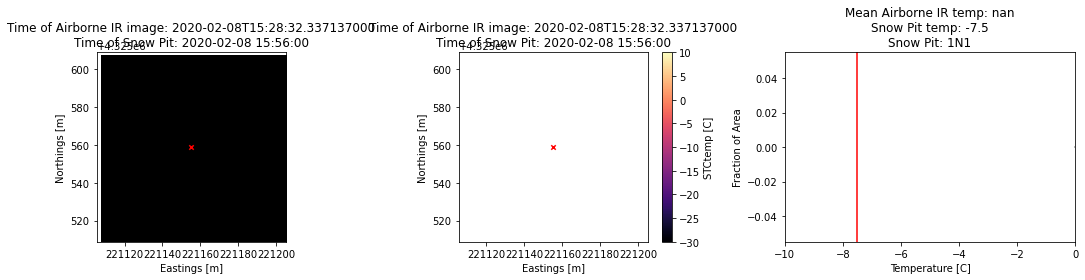

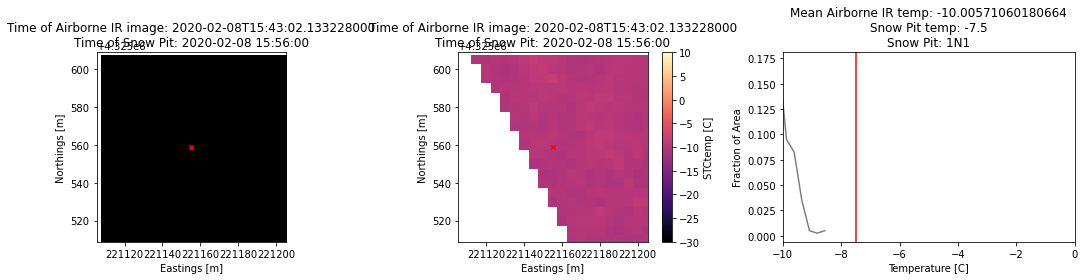

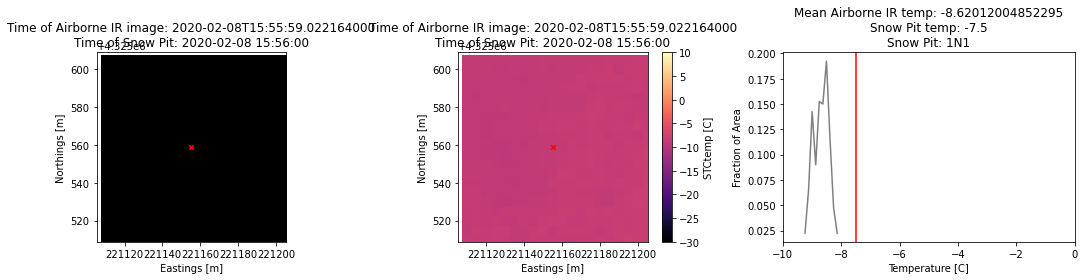

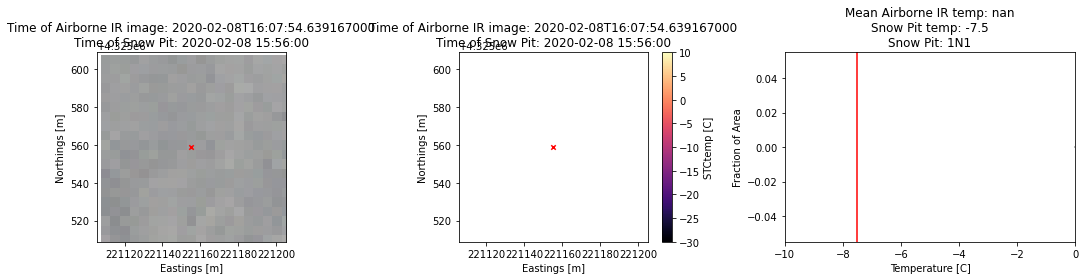

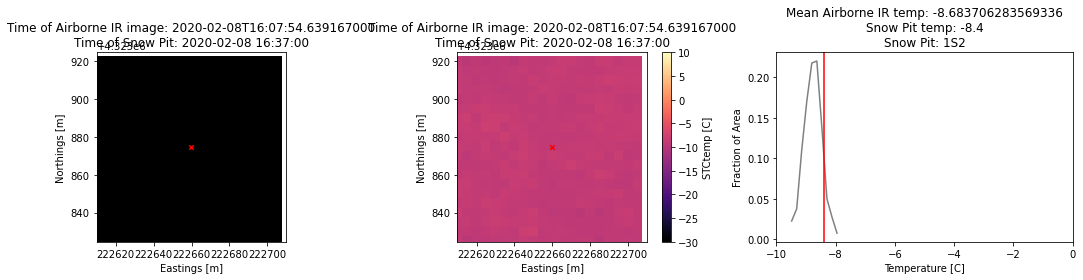

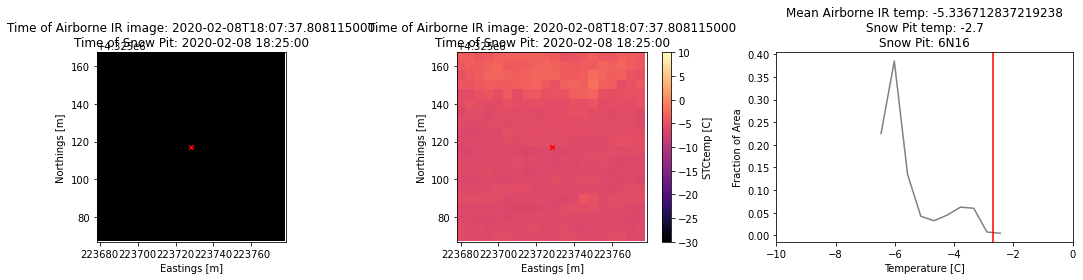

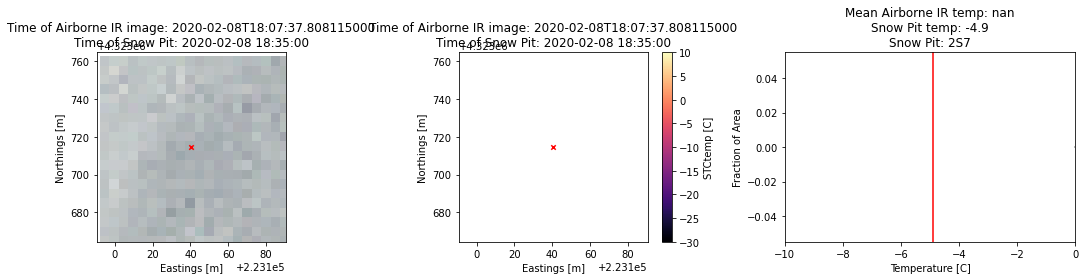

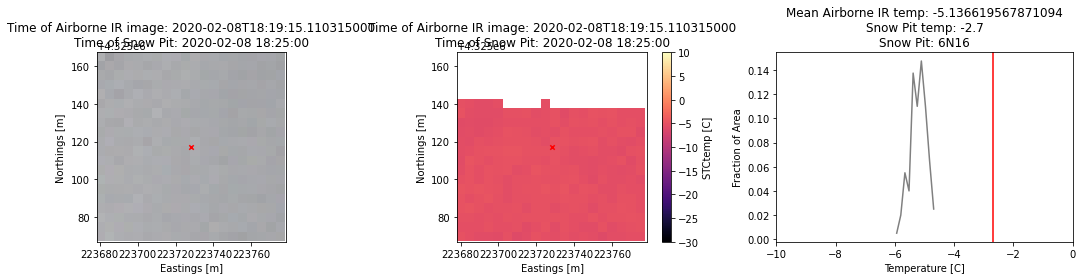

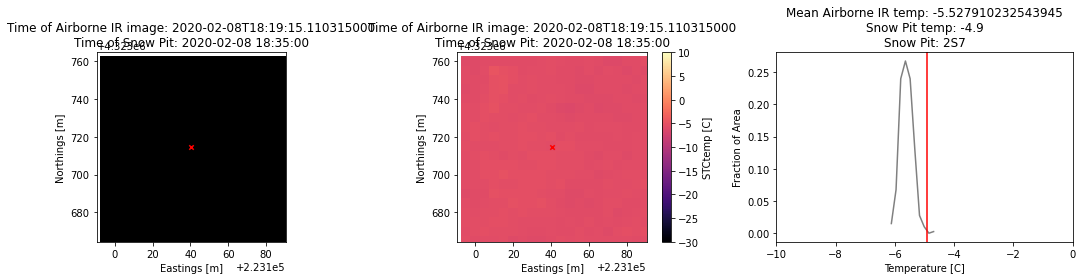

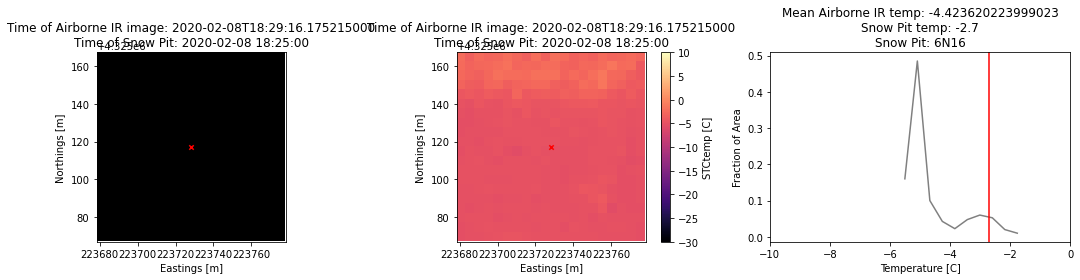

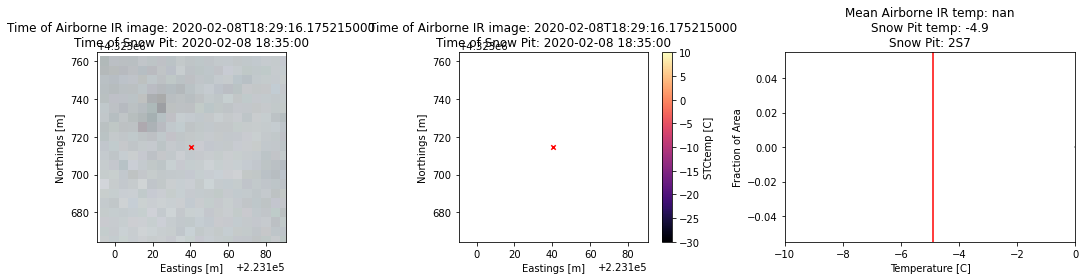

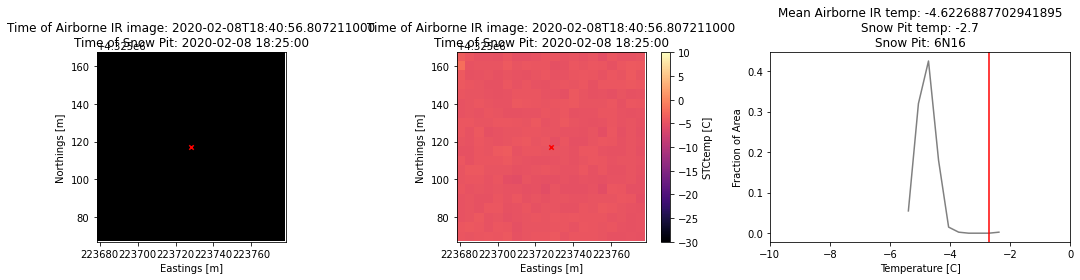

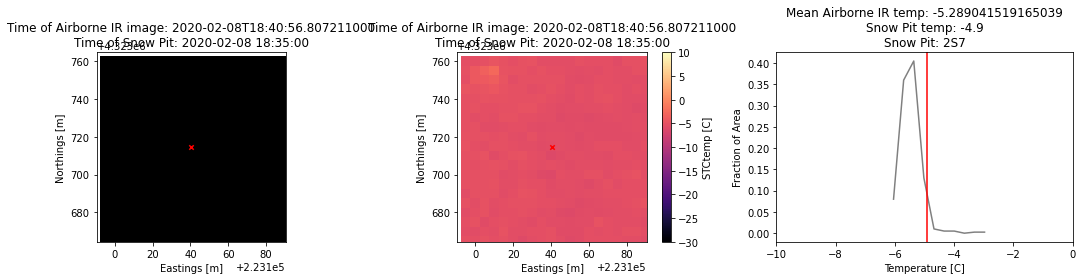

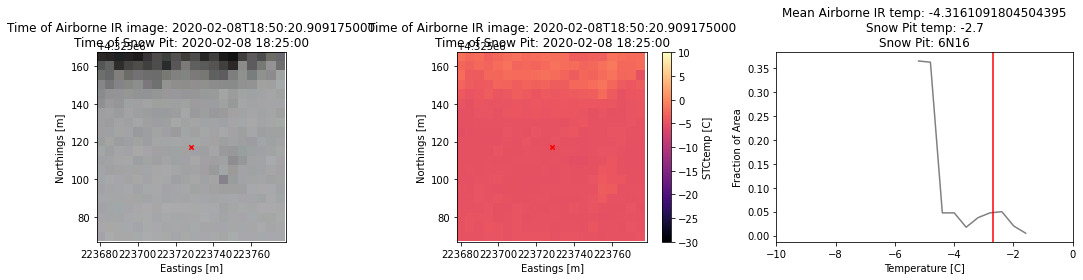

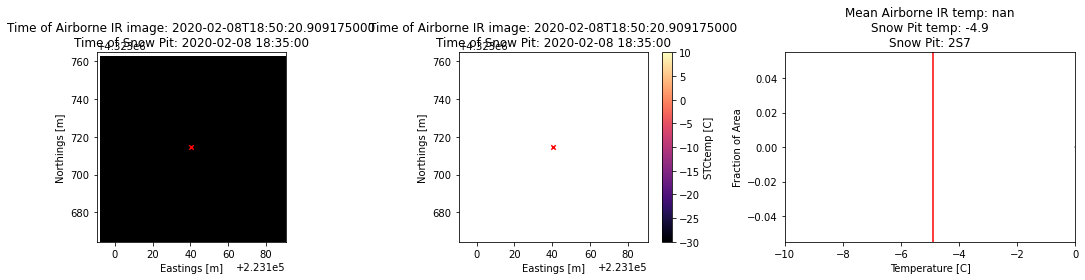

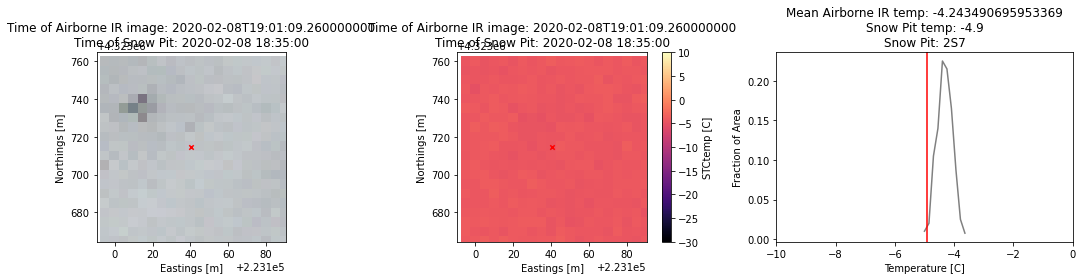

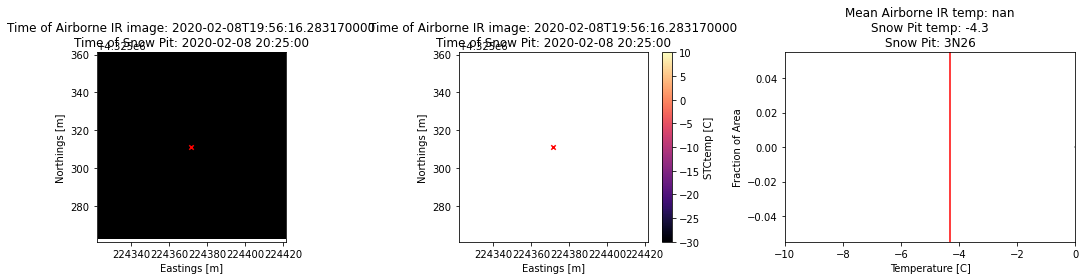

In [126]:
snowpit_temperatures = []
airborne_ir_mean_temperatures = []
airborne_ir_std_temperatures = []
snowpit_time = []
airborne_snowpit_time_difference = []
airborne_ir_time = []

for time_index, time_step in enumerate(ds_ir.time):
    # set a start and endtime to search for snow pit data
    starttime = pd.to_datetime(time_step.values) - datetime.timedelta(minutes=plus_minus_minutes)
    endtime = pd.to_datetime(time_step.values) + datetime.timedelta(minutes=plus_minus_minutes)
    # select snowpit data from this time window
    df_tss_time_window = df_tss[starttime:endtime]
    
    if len(df_tss_time_window) > 0:
        # for each snow pit in this time window
        for i, snow_pit in df_tss_time_window.iterrows():

            # get a window around the snow pit
            utm_xmin, utm_xmax = snow_pit.easting-x, snow_pit.easting+x
            utm_ymin, utm_ymax = snow_pit.northing-x, snow_pit.northing+x

            
            fig, [ax_vis, ax_img, ax_hist] = plt.subplots(ncols=3, nrows=1, figsize=(15,4), tight_layout=True)
            
            # plot visible image
            ds_eo.SRGB.isel(time=time_index).sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax)).plot.imshow(ax=ax_vis)

            
            # plot the IR image
            ds_ir.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).plot.imshow(cmap='magma', vmin=-30, vmax=10, ax=ax_img)
            

            for this_ax in [ax_vis, ax_img]:
                # plot the snow pit point
                df_tss_time_window.plot.scatter(x='easting', y='northing', color='r', marker='x', zorder=999, ax=this_ax)
                # formatting
                this_ax.set_xlim((utm_xmin, utm_xmax))
                this_ax.set_ylim((utm_ymin, utm_ymax))
                this_ax.set_aspect('equal', 'box')
                this_ax.set_ylabel('Northings [m]')
                this_ax.set_xlabel('Eastings [m]')
                this_ax.set_title(f'Time of Airborne IR image: {str(time_step.values)}\nTime of Snow Pit: {str(snow_pit.name)}')
                
                
            # plot histograms
            data = ds_ir.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).values
            data_n_pixels = data.shape[0]*data.shape[1]
            try:
                hist_data = data[~np.isnan(data)]
                y_hist, x_hist = np.histogram(hist_data, bins=10, density=False)
                ax_hist.plot(x_hist[:-1], y_hist/data_n_pixels, color='grey')
                ax_hist.axvline(snow_pit.temperature, color='r')
                ax_hist.set_xlim(-10, 0)
                #ax_hist.set_ylim(0,2)
                ax_hist.set_ylabel('Fraction of Area')
                ax_hist.set_xlabel('Temperature [C]')

                ax_hist.set_title(f'Mean Airborne IR temp: {np.mean(hist_data)}\nSnow Pit temp: {snow_pit.temperature}\nSnow Pit: {snow_pit.site_id}')
            except ValueError as e:
                print(e)
                None
                
            snowpit_temperatures.append(snow_pit.temperature)
            airborne_ir_mean_temperatures.append(np.mean(hist_data))
            airborne_ir_std_temperatures.append(np.std(hist_data))
            snowpit_time.append(snow_pit.name)
            airborne_ir_time.append(time_step.values)
            airborne_snowpit_time_difference.append(time_step.values - snow_pit.name)
            
airborne_snowpit_time_difference = [this_timedelta.total_seconds()/60 for this_timedelta in airborne_snowpit_time_difference]

Text(0.5, 0, 'Time difference (minutes)')

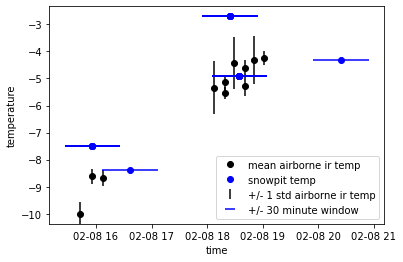

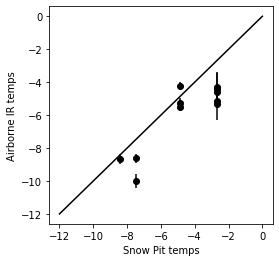

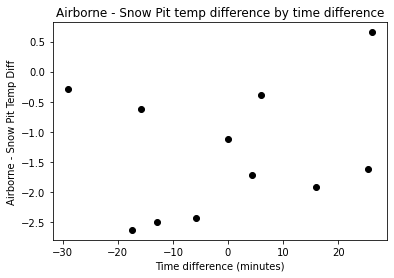

In [127]:
plt.figure()
plt.errorbar(airborne_ir_time, airborne_ir_mean_temperatures, yerr=airborne_ir_std_temperatures, color='k', linestyle='none', label='+/- 1 std airborne ir temp')
plt.plot(airborne_ir_time, airborne_ir_mean_temperatures, 'ok', label='mean airborne ir temp')
plt.errorbar(snowpit_time, snowpit_temperatures, xerr=datetime.timedelta(minutes=plus_minus_minutes), color='b', linestyle='none', label=f'+/- {plus_minus_minutes} minute window')
plt.plot(snowpit_time, snowpit_temperatures, 'ob', label='snowpit temp')
plt.legend()
plt.ylabel('temperature')
plt.xlabel('time')

plt.figure(figsize=(4,4))
plt.plot(snowpit_temperatures, airborne_ir_mean_temperatures, linestyle='none', marker='o', color='k')
plt.errorbar(snowpit_temperatures, airborne_ir_mean_temperatures, yerr=airborne_ir_std_temperatures, color='k', linestyle='none', label='+/- 1 std airborne ir temp', zorder=-1)
plt.plot([-12,0],[-12,0],'-k',zorder=-999)
plt.xlabel('Snow Pit temps')
plt.ylabel('Airborne IR temps')

plt.figure()
plt.plot(airborne_snowpit_time_difference, np.array(airborne_ir_mean_temperatures)-np.array(snowpit_temperatures), 'ok')
plt.title('Airborne - Snow Pit temp difference by time difference')
plt.ylabel('Airborne - Snow Pit Temp Diff')
plt.xlabel('Time difference (minutes)')

Feb 11

In [128]:
ds_eo = ir_utils.eo_mat2dataset(files[3])
#ds_eo['SRGB'] = ds_eo.SRGB.transpose('time', 'y', 'x','band')

ds_ir = ir_utils.ir_mat2dataset(files[2])

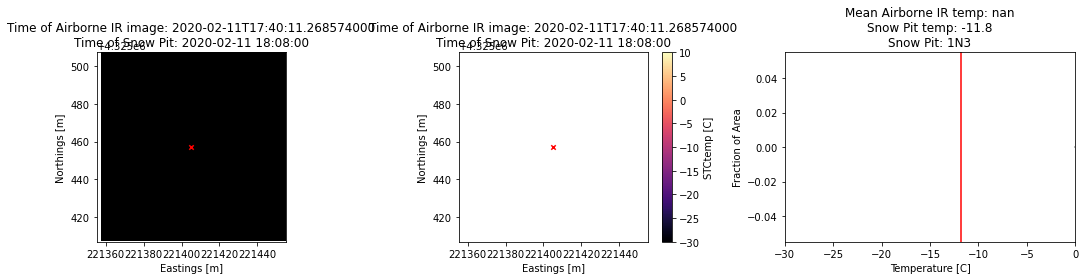

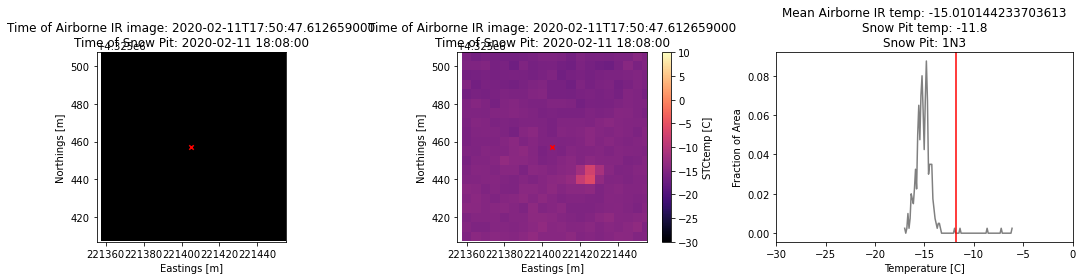

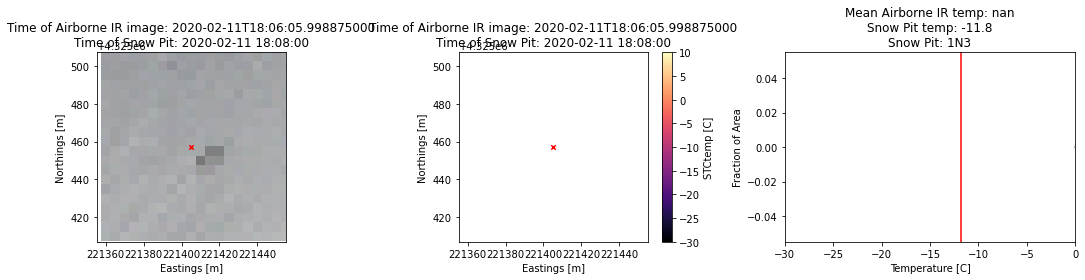

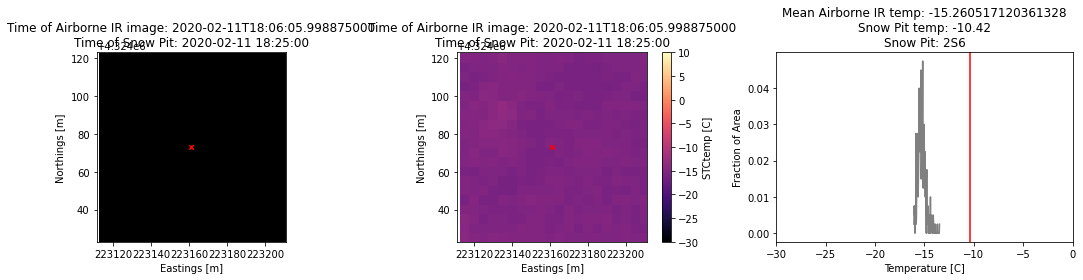

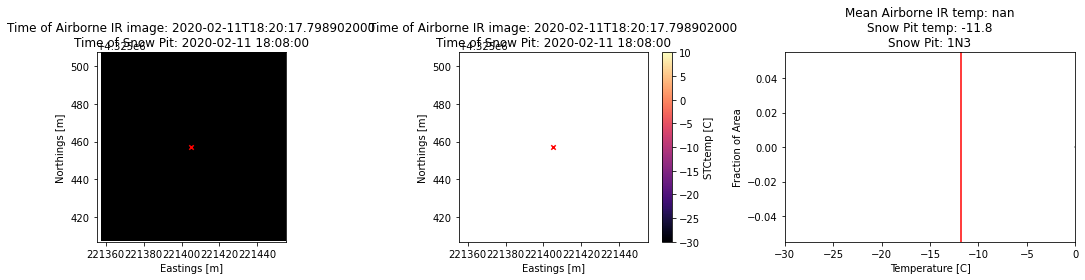

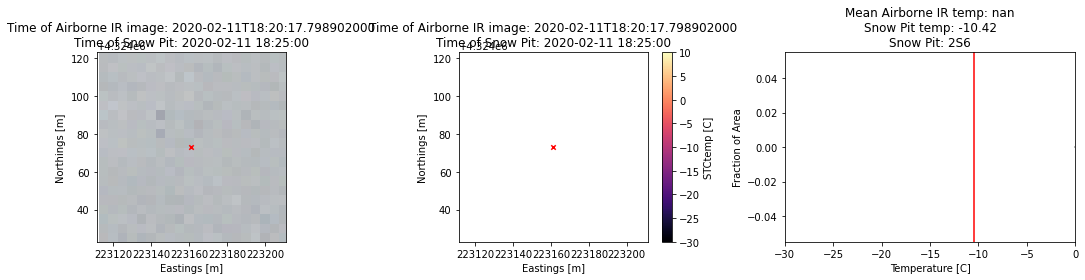

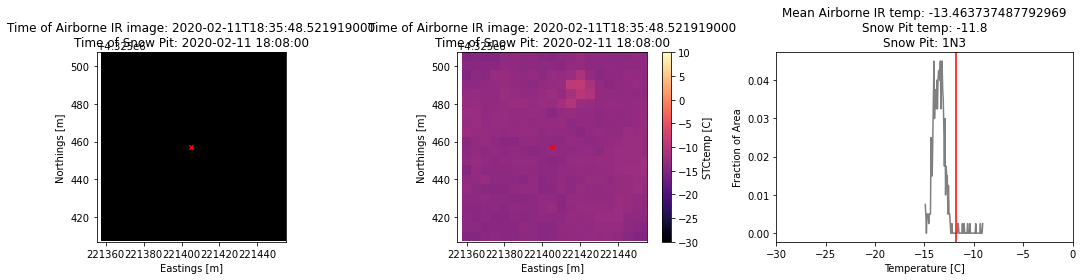

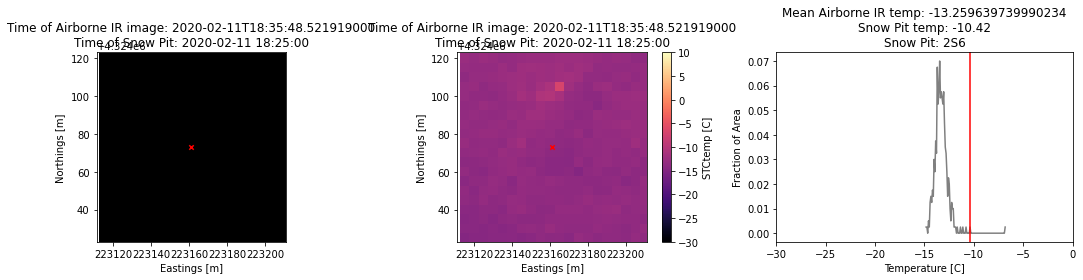

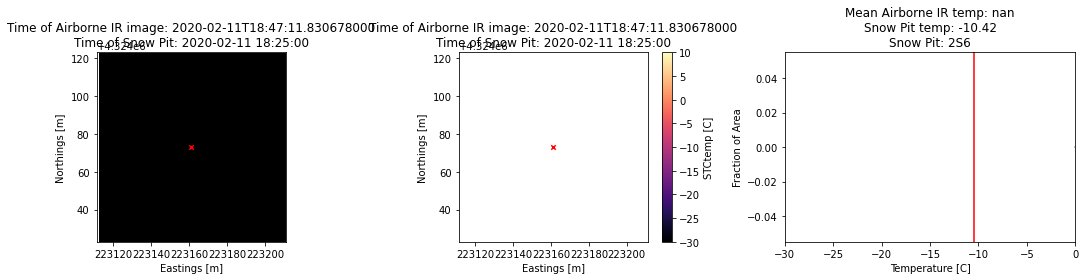

In [129]:
snowpit_temperatures = []
airborne_ir_mean_temperatures = []
airborne_ir_std_temperatures = []
snowpit_time = []
airborne_snowpit_time_difference = []
airborne_ir_time = []

for time_index, time_step in enumerate(ds_ir.time):
    # set a start and endtime to search for snow pit data
    starttime = pd.to_datetime(time_step.values) - datetime.timedelta(minutes=plus_minus_minutes)
    endtime = pd.to_datetime(time_step.values) + datetime.timedelta(minutes=plus_minus_minutes)
    # select snowpit data from this time window
    df_tss_time_window = df_tss[starttime:endtime]
    
    if len(df_tss_time_window) > 0:
        # for each snow pit in this time window
        for i, snow_pit in df_tss_time_window.iterrows():

            # get a window around the snow pit
            utm_xmin, utm_xmax = snow_pit.easting-x, snow_pit.easting+x
            utm_ymin, utm_ymax = snow_pit.northing-x, snow_pit.northing+x

            
            fig, [ax_vis, ax_img, ax_hist] = plt.subplots(ncols=3, nrows=1, figsize=(15,4), tight_layout=True)
            
            # plot visible image
            ds_eo.SRGB.isel(time=time_index).sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax)).plot.imshow(ax=ax_vis)

            
            # plot the IR image
            ds_ir.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).plot.imshow(cmap='magma', vmin=-30, vmax=10, ax=ax_img)
            

            for this_ax in [ax_vis, ax_img]:
                # plot the snow pit point
                df_tss_time_window.plot.scatter(x='easting', y='northing', color='r', marker='x', zorder=999, ax=this_ax)
                # formatting
                this_ax.set_xlim((utm_xmin, utm_xmax))
                this_ax.set_ylim((utm_ymin, utm_ymax))
                this_ax.set_aspect('equal', 'box')
                this_ax.set_ylabel('Northings [m]')
                this_ax.set_xlabel('Eastings [m]')
                this_ax.set_title(f'Time of Airborne IR image: {str(time_step.values)}\nTime of Snow Pit: {str(snow_pit.name)}')
                
                
            # plot histograms
            data = ds_ir.STCtemp.sel(x=slice(utm_xmin, utm_xmax),y=slice(utm_ymin, utm_ymax), time=time_step).values
            data_n_pixels = data.shape[0]*data.shape[1]
            try:
                hist_data = data[~np.isnan(data)]
                y_hist, x_hist = np.histogram(hist_data, bins=100, density=False)
                ax_hist.plot(x_hist[:-1], y_hist/data_n_pixels, color='grey')
                ax_hist.axvline(snow_pit.temperature, color='r')
                ax_hist.set_xlim(-30, 0)
                #ax_hist.set_ylim(0,2)
                ax_hist.set_ylabel('Fraction of Area')
                ax_hist.set_xlabel('Temperature [C]')

                ax_hist.set_title(f'Mean Airborne IR temp: {np.mean(hist_data)}\nSnow Pit temp: {snow_pit.temperature}\nSnow Pit: {snow_pit.site_id}')
            except ValueError as e:
                print(e)
                None
                
                       
            snowpit_temperatures.append(snow_pit.temperature)
            airborne_ir_mean_temperatures.append(np.mean(hist_data))
            airborne_ir_std_temperatures.append(np.std(hist_data))
            snowpit_time.append(snow_pit.name)
            airborne_ir_time.append(time_step.values)
            airborne_snowpit_time_difference.append(time_step.values - snow_pit.name)
            
airborne_snowpit_time_difference = [this_timedelta.total_seconds()/60 for this_timedelta in airborne_snowpit_time_difference]

Text(0.5, 0, 'Time difference (minutes)')

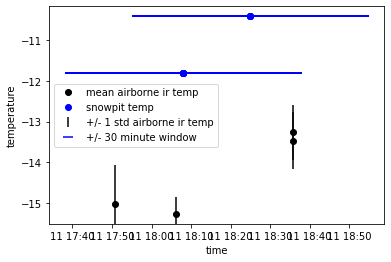

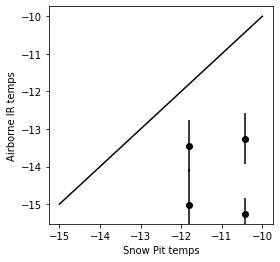

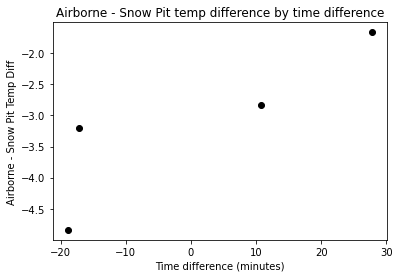

In [130]:
plt.figure()
plt.errorbar(airborne_ir_time, airborne_ir_mean_temperatures, yerr=airborne_ir_std_temperatures, color='k', linestyle='none', label='+/- 1 std airborne ir temp')
plt.plot(airborne_ir_time, airborne_ir_mean_temperatures, 'ok', label='mean airborne ir temp')
plt.errorbar(snowpit_time, snowpit_temperatures, xerr=datetime.timedelta(minutes=plus_minus_minutes), color='b', linestyle='none', label=f'+/- {plus_minus_minutes} minute window')
plt.plot(snowpit_time, snowpit_temperatures, 'ob', label='snowpit temp')
plt.legend()
plt.ylabel('temperature')
plt.xlabel('time')

plt.figure(figsize=(4,4))
plt.plot(snowpit_temperatures, airborne_ir_mean_temperatures, linestyle='none', marker='o', color='k')
plt.errorbar(snowpit_temperatures, airborne_ir_mean_temperatures, yerr=airborne_ir_std_temperatures, color='k', linestyle='none', label='+/- 1 std airborne ir temp', zorder=-1)
plt.plot([-15,-10],[-15,-10],'-k',zorder=-999)
plt.xlabel('Snow Pit temps')
plt.ylabel('Airborne IR temps')

plt.figure()
plt.plot(airborne_snowpit_time_difference, np.array(airborne_ir_mean_temperatures)-np.array(snowpit_temperatures), 'ok')
plt.title('Airborne - Snow Pit temp difference by time difference')
plt.ylabel('Airborne - Snow Pit Temp Diff')
plt.xlabel('Time difference (minutes)')